In [1]:
import torch
import pickle
import numpy as np
import sklearn.utils
import argparse
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

from model import ExponentialKernelFiringRateModel, PolynomialActivation
from train import train_model, fit_activation
from evaluate import explained_variance_ratio
from data import get_data, get_train_test_data, preprocess_data

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cpu


In [21]:
def get_activations(
    Is,
    fs,
    bin_size, 
    epochs=1000, 
    repeats=1,
    max_firing_rate=100,
    degree=1,
    device=None
):  
    max_current = np.max(np.abs(Is.cpu().numpy()))
    gs = []
    losses = []
    best_g = None
    best_loss = 1e10
    
    for i in range(repeats):
        g = PolynomialActivation.from_data(degree, max_current, max_firing_rate, bin_size, Is, fs).to(device)
        criterion = torch.nn.PoissonNLLLoss(log_input=False)
        optimizer = torch.optim.Adam(g.parameters(), lr=0.05)

        ls = fit_activation(
            g,
            criterion,
            optimizer,
            Is,
            fs,
            epochs=epochs,
        )
        loss = ls[-1]
        print(f"Repeat {i}, final loss {loss}")
        if loss < best_loss:
            best_g, best_loss = g, loss
        gs.append(best_g)
        losses.append(best_loss)
    return gs[np.argmin(losses)]

def train(
    Is_tr, 
    fs_tr, 
    Is_val, 
    fs_val, 
    Is_te, 
    fs_te,  
    g,
    ds,
    cell_id, 
    bin_size,  
    device = None,
    hparams=[{"lr": 1e-3, "gamma": 0.5, "step_size": 30, "epochs": 200}],
    C=0
):
    best_model, best_evr1, best_losses, best_test_losses = None, -1e10, [], []
    
    for i, hs in enumerate(hparams):
        print(f"Run {i+1}/{len(hparams)}: {hs}")

        model = ExponentialKernelFiringRateModel(
            g, ds, bin_size, freeze_g=True, device=device
        ).to(device)

        criterion = torch.nn.PoissonNLLLoss(log_input=False, reduction="none", eps=1e-6)
        optimizer = torch.optim.Adam(model.parameters(), lr=hs["lr"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=hs["gamma"], step_size=hs["step_size"])

        losses, test_losses = train_model(
            model, 
            criterion, 
            optimizer,
            Is_tr,
            fs_tr,
            Is_te,
            fs_te,
            epochs = hs["epochs"],
            print_every = 1,
            bin_size = bin_size,
            scheduler = None,
            C = C
        )
        
        evr1 = explained_variance_ratio(model, Is_val[0], fs_val[0], bin_size)
        
        if evr1 > best_evr1:
            best_evr1 = evr1
            best_losses = losses
            best_test_losses = test_losses
            best_model = model
    
    best_evr2 = explained_variance_ratio(best_model, Is_te[0], fs_te[0], bin_size)
    
    return best_model, best_evr1, best_evr2, best_losses, best_test_losses

def fit_model(cell_id, bin_size, activation_bin_size, degree, max_firing_rate, C, device=None, g=None):
    print("Loading data for activation")
    aligned_data = get_data(cell_id, aligned=True)
    Is, fs = preprocess_data(aligned_data, activation_bin_size)
    Is, fs = torch.tensor(Is).to(device), torch.tensor(fs).to(device) # shape [seq_length]
    
    if g is None:
        print("Fitting activation")
        # get best activation
        g = get_activations(
            Is,
            fs,
            activation_bin_size, 
            epochs=1000, 
            repeats=1,
            max_firing_rate=max_firing_rate,
            degree=degree,
            device=torch.device("cpu")
        )

    if g is None:
        print(f"Error: activation for cell {cell_id} is None")
        print(f"Sum of firing rates (for activation fit): {torch.sum(fs)}")
        raise Exception
    else:
        print("Loading data for model...")

        taus = torch.tensor([10, 20, 50, 100, 200, 500, 1000, 2000])
        taus = taus[taus >= bin_size]
        ds = 1 - torch.exp(-bin_size /  taus)
        ds = torch.cat([torch.ones(1), ds])
        ds = ds.to(torch.float32)
        print(f"Using timescales: {taus}")
        print(f"Corresponding decay rates: {ds}")

        data = get_data(cell_id, aligned=False)
        Is_tr, fs_tr, Is_val, fs_val, Is_te, fs_te, stims = get_train_test_data(data, bin_size, device=device)
        Is_tr, fs_tr, stims = sklearn.utils.shuffle(Is_tr, fs_tr, stims) # list of Tensors, each with shape [B, seq_len]
        
        if len(Is_te) == 0 or len(Is_val) == 0:
            print("No noise 1/2 data. Skipping.")
            raise Exception
        
        print("Start training model...")
        model, evr1, evr2, losses, test_losses = train(
            Is_tr, fs_tr, Is_val, fs_val, Is_te, fs_te, g.to(device), ds, cell_id, bin_size, device=device, C=C
        )
        
        print(f"{evr1}, {evr2}")
        
        return model.get_params(), evr1, evr2, losses, test_losses

def model_pipeline(cell_id, bin_size, activation_bin_size, degree, max_firing_rate, C, device):        
    retrain = False
    params_old = None
    g = None

    if os.path.isfile(f"model/params_test/{cell_id}.pickle"):
        print("Model already exists")
        with open(f"model/params_test/{cell_id}.pickle", 'rb') as f:
            params_old = pickle.load(f)
            g = PolynomialActivation.from_params(params_old["params"]["g"])
    else:
        print("Model doesn't exist")
            
    if retrain or params_old is None or g is None:
        p, evr1, evr2, losses, test_losses = fit_model(
            cell_id, bin_size, activation_bin_size, degree, max_firing_rate, C, device=device, g=g
        )

        params = {
            "params": p,
            "evr1": evr1,
            "evr2": evr2,
            "train_losses": losses,
            "test_losses": test_losses,
            "bin_size": bin_size
        }
        
        # referesh parameters
        if params_old is not None:
            with open(f"model/params_test/{cell_id}.pickle", 'rb') as f:
                params_old = pickle.load(f)
        
        if params_old is None or evr1 > params_old["evr1"]:
            print("Saving model params")
            with open(f'model/params_test/{cell_id}.pickle', 'wb') as handle:
                pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
bin_size = 20
activation_bin_size = 20
degree = 1
C = 0.1

cell_id = 605889373

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cell_ids = [cell_id]

print(f"{device=}\n{bin_size=}\n{activation_bin_size=}\n{degree=}\n{C=}")

for i, cell_id in enumerate(cell_ids):
    print(f"({i+1}/{len(cell_ids)}) Cell {cell_id}")
    try:
        with open(f"model/max_firing_rates/{cell_id}.pickle", "rb") as f:
            max_firing_rate = pickle.load(f)
        model_pipeline(cell_id, bin_size, activation_bin_size, degree, max_firing_rate, C, device)
    except Exception as e:
        print(f"Skipping {cell_id} due to error: {e}")

device=device(type='cpu')
bin_size=20
activation_bin_size=20
degree=1
C=0.1
(1/1) Cell 605889373
Model doesn't exist
Loading data for activation
Fitting activation
Repeat 0, final loss 3.2136588096618652
Loading data for model...
Using timescales: tensor([  20,   50,  100,  200,  500, 1000, 2000])
Corresponding decay rates: tensor([1.0000, 0.6321, 0.3297, 0.1813, 0.0952, 0.0392, 0.0198, 0.0100])
Start training model...
Run 1/1: {'lr': 0.001, 'gamma': 0.5, 'step_size': 30, 'epochs': 200}
Epoch 1 | Loss: 1.0016027498536348
Epoch 2 | Loss: 1.0435388520814852
Epoch 3 | Loss: 1.0434331790984623
Epoch 4 | Loss: 1.043384493500613
Epoch 5 | Loss: 1.043901860350072
Epoch 6 | Loss: 1.043559057401068
Epoch 7 | Loss: 1.0427376030070732
Epoch 8 | Loss: 1.0456077309260294
Epoch 9 | Loss: 1.0434183411836915
Epoch 10 | Loss: 1.0438832379202558
Epoch 11 | Loss: 1.043083266559829
Epoch 12 | Loss: 1.044697998568543
Epoch 13 | Loss: 1.0500860044225524
Epoch 14 | Loss: 1.0527079255007417
Epoch 15 | Loss: 1

In [23]:
def plot_kernel(model, cell_id, bin_size, save=False, fname=None, xlim=10):
    fig = plt.figure(constrained_layout=True, figsize=(8, 4.5), dpi=100)
    subfigs = fig.subfigures(1, 2)
    #fig.suptitle(f"cell_id={cell_id}, bin_size={bin_size}")
    xs = torch.linspace(0, xlim, 100)
    cs, ds = [], []
    with torch.no_grad():
        for x in xs:
            cs.append(model.kernel(x, var="a"))
            ds.append(model.kernel(x, var="b"))
    
    xs = xs * bin_size / 1000
    
    axs0 = subfigs[0].subplots(2)
    axs0[0].plot(xs,cs, linewidth=2)
    axs0[1].plot(xs,ds, linewidth=2)
    axs0[0].set_ylabel("$k_I(t)$")
    axs0[1].set_ylabel("$k_f(t)$")
    axs0[1].set_xlabel("$t$ $(s)$")
    
    axs1 = subfigs[1].subplots(2)
    taus = torch.tensor([0, 20, 50, 100, 200, 500, 1000, 2000])
    ks = [f"{i}" for i in taus]
    axs1[0].bar(ks, model.a.detach().reshape(-1))
    axs1[1].bar(ks, model.b.detach().reshape(-1))
    axs1[0].set_ylabel("$\\alpha_i$")
    axs1[1].set_ylabel("$\\beta_i$")
    axs1[1].set_xlabel("$\\tau_i$ (ms)")
    
    #fig.set_size_inches(8, 4.5, forward=True)

    if save:
        plt.savefig(config["fig_save_path"] + f"{cell_id}/bin_size_{bin_size}/{fname}.png")
        plt.close()

def plot_predictions(model, Is, fs, cell_id, bin_size, evr=None, xlim=None):
    pred_fs, vs = model.predict(Is)
    pred_fs = torch.cat([torch.zeros(1), pred_fs])
    vs = torch.cat([torch.zeros(1, model.ds.shape[0]), vs])
    Is = torch.cat([torch.zeros(1), Is])
    fs = torch.cat([torch.zeros(1), fs])
    ts = np.arange(Is.shape[0]) * bin_size / 1000
    

    fig, axs = plt.subplots(2, figsize=(6, 2.5), dpi=100)
    
    axs[1].plot(ts, fs, label="Actual", linewidth=1)
    axs[1].plot(ts, pred_fs, label="Predicted", linewidth=1)
    #axs[2].plot(ts, vs, linewidth=1)
    axs[0].plot(ts, Is, linewidth=1)
    axs[1].legend()
    axs[1].set_ylabel("$f_t$ $(ms^{-1})$")
    #axs[2].set_ylabel("$\mathbf{h}_t$")
    axs[0].set_ylabel("$I_t$ $(pA)$")
    if xlim is not None:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)
        #axs[2].set_xlim(xlim)
    #axs[0].yaxis.set_ticklabels([])
    #axs[1].yaxis.set_ticklabels([])
    axs[0].set_ylim([-10, 230])
    axs[1].set_ylim([-0.003, 0.06])
    axs[0].xaxis.set_ticklabels([])
    #axs[1].xaxis.set_ticklabels([])
    #axs[2].xaxis.set_ticklabels([])
    axs[1].set_xlabel("$t$ $(s)$")
    fig.tight_layout()
    
def visualize(cell_id, params, bin_size=20):
    model = ExponentialKernelFiringRateModel.from_params(params["params"])
    data = get_data(cell_id, aligned=True)
    Is_tr, fs_tr, _, _, Is_te, fs_te, stims = get_train_test_data(data, bin_size)
    Is_actv, fs_actv = preprocess_data(data, bin_size=params["params"]["g"]["bin_size"])
    
    def _plot_train_data():
        for Is, fs, s in zip(Is_tr, fs_tr, stims):
            if torch.sum(fs) > 0.2:
                for i in range(Is.shape[0]):
                    plot_predictions(
                        model, 
                        Is[i, :], 
                        fs[i, :], 
                        cell_id, 
                        bin_size, 
                        evr = None
                    )
                
    def _plot_noise2():
        r = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size)
        print(r)
        print(Is_te[0][0, :].shape)
        plot_predictions(
            model, 
            Is_te[0][0, :], 
            fs_te[0][0, :], 
            cell_id, 
            bin_size, 
            evr = r,
            xlim = [15, 20]
        )
    
    def _plot_kernel():
        plot_kernel(
            model,
            cell_id,
            bin_size,
            save = False,
            xlim = 25
        )
    
    def _plot_losses():
        train_losses = params["train_losses"]
        test_losses = params["test_losses"]
        plt.figure()
        plt.plot(list(range(len(train_losses))), train_losses, label="train")
        plt.plot(list(range(len(test_losses))), test_losses, label="test")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        
    _plot_train_data()
    _plot_noise2()
    _plot_kernel()
    _plot_losses()

/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_91342/2128370437.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, figsize=(6, 2.5), dpi=100)


0.7370517134441444
torch.Size([1300])


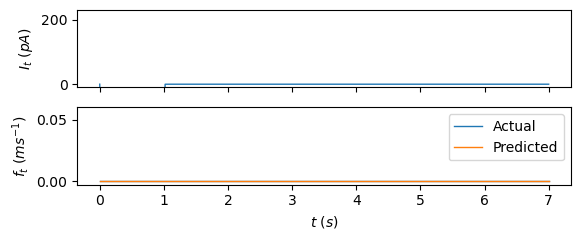

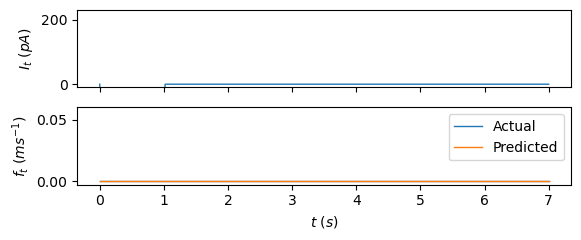

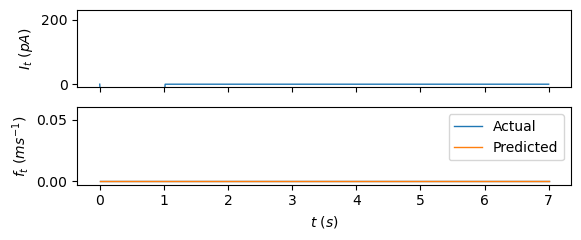

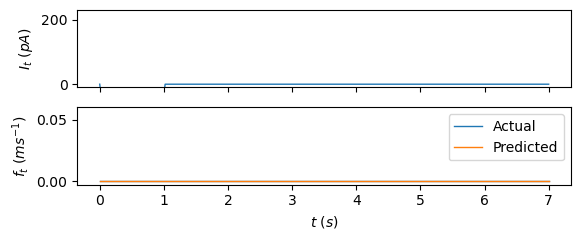

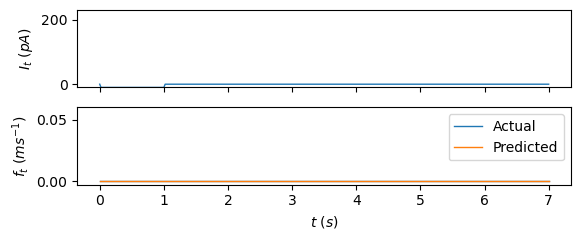

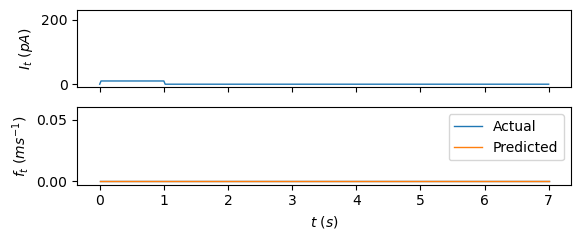

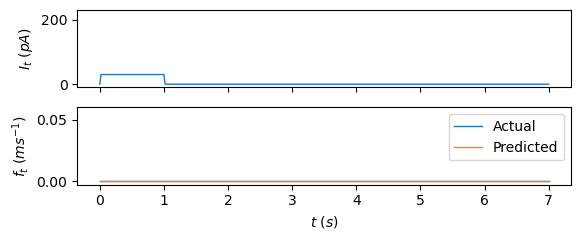

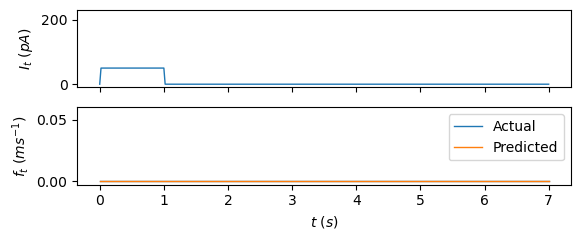

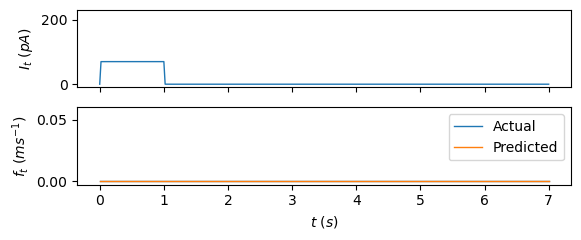

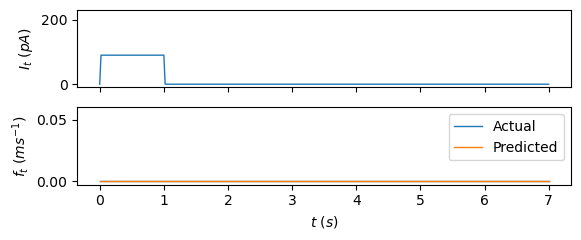

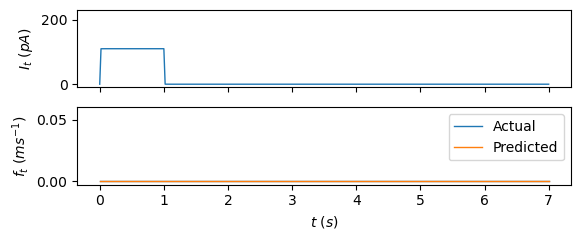

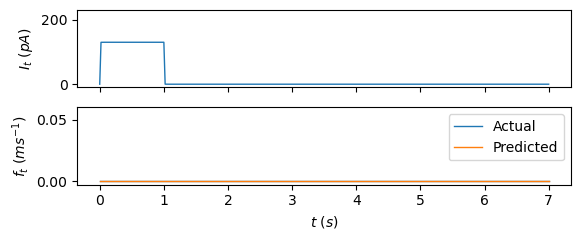

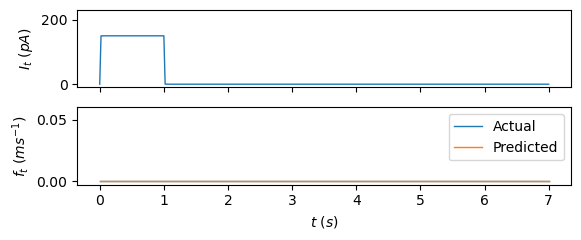

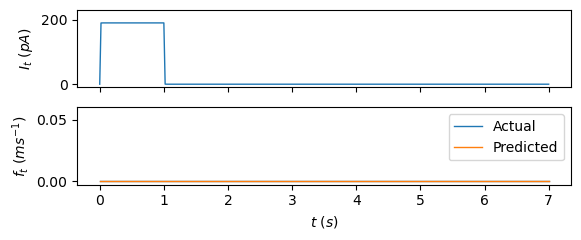

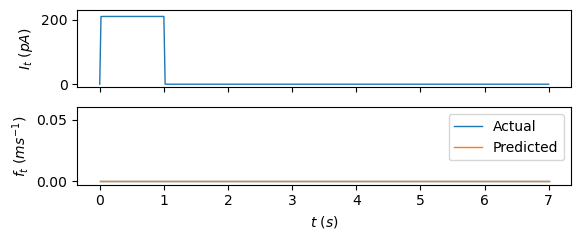

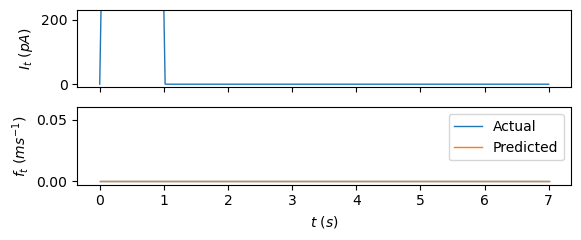

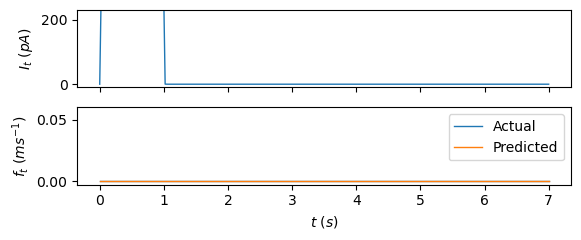

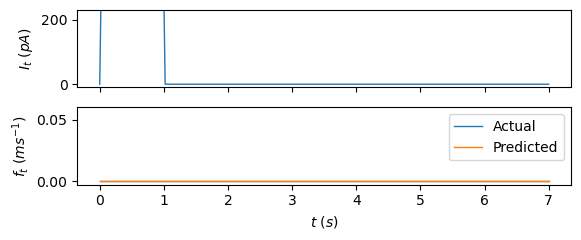

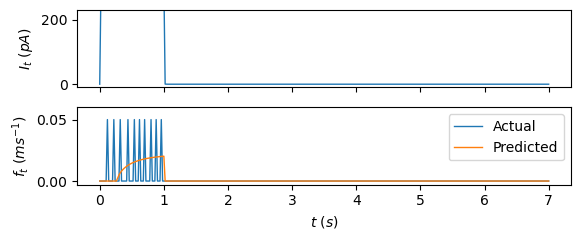

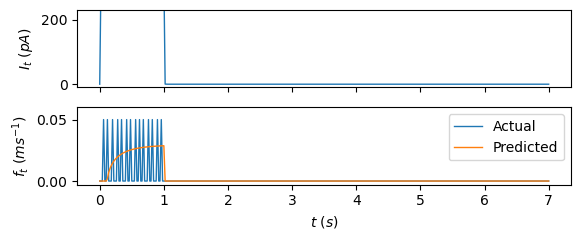

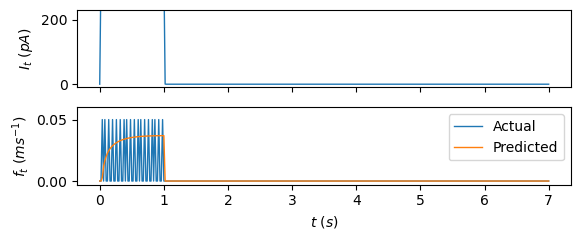

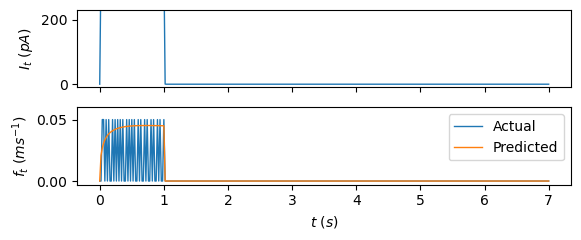

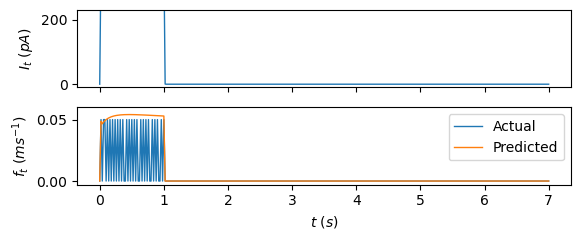

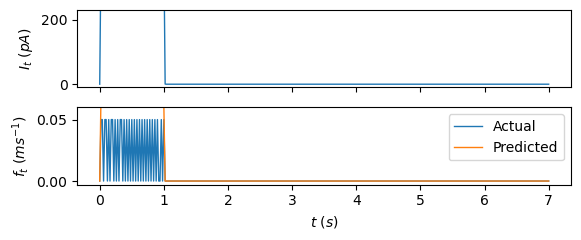

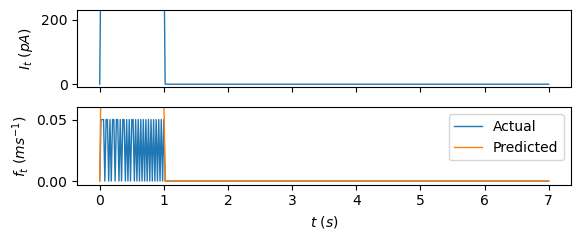

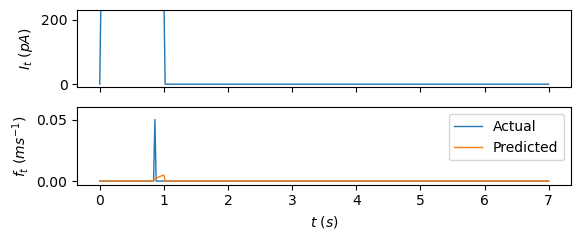

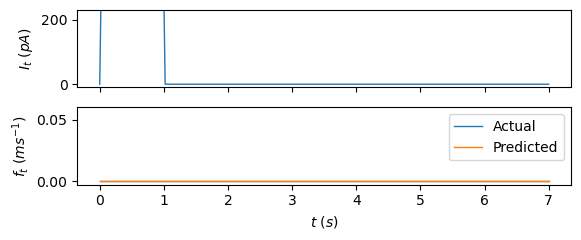

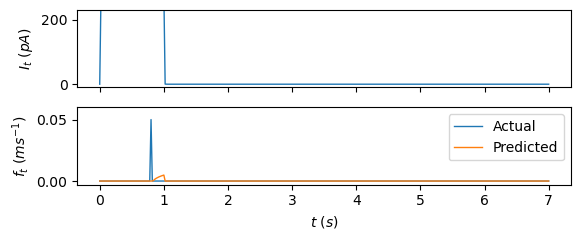

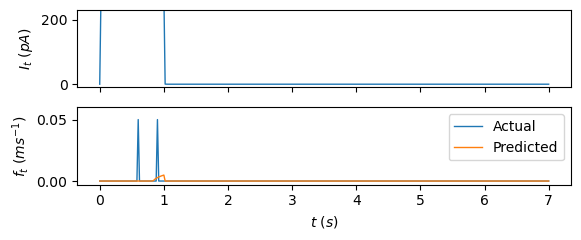

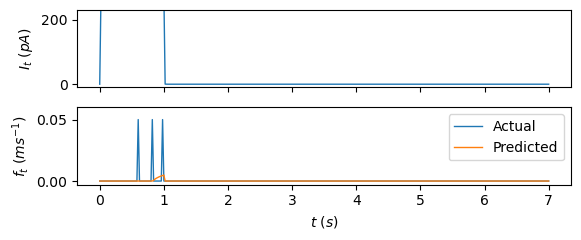

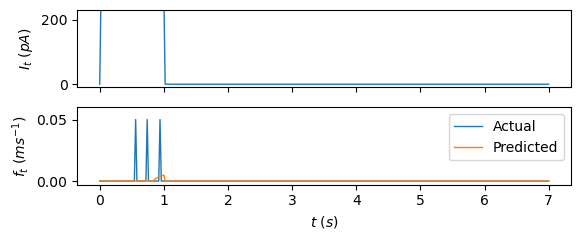

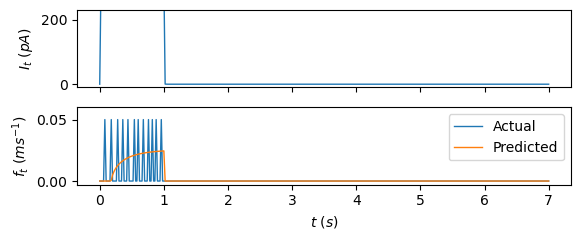

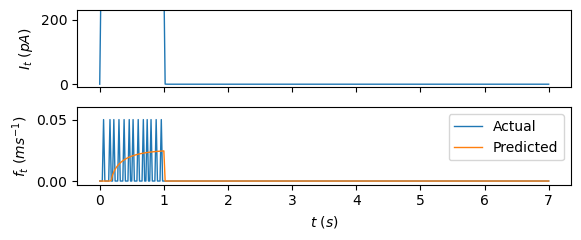

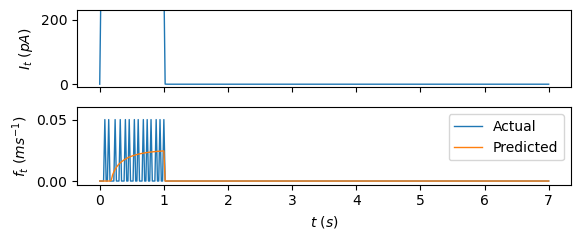

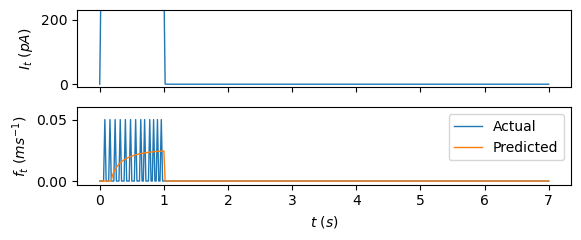

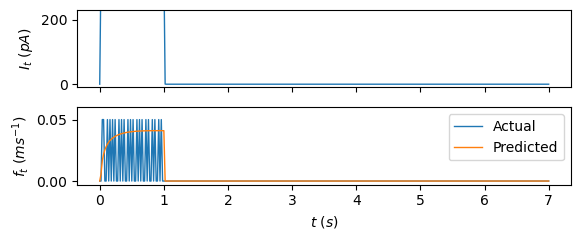

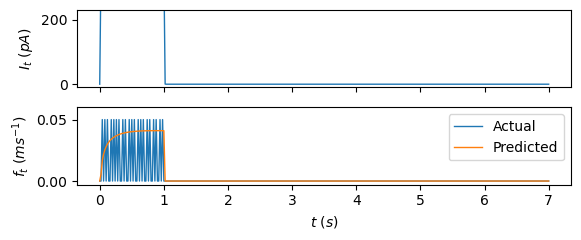

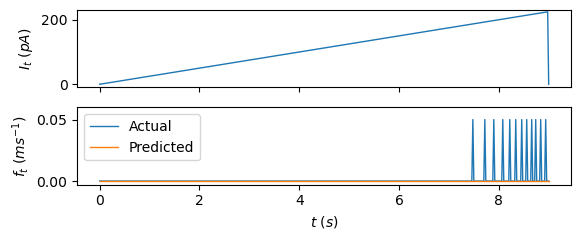

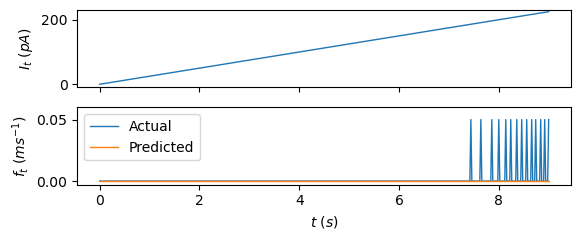

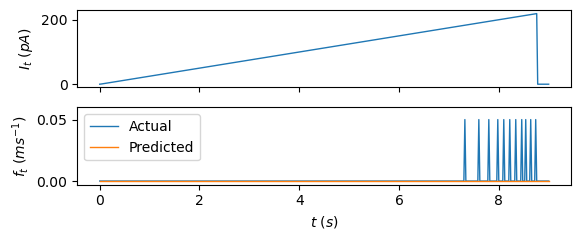

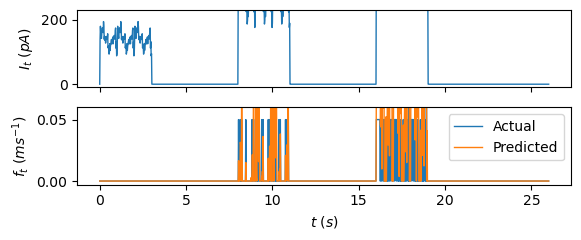

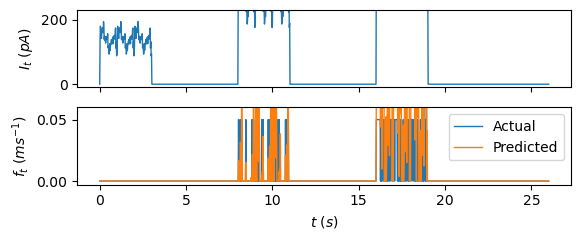

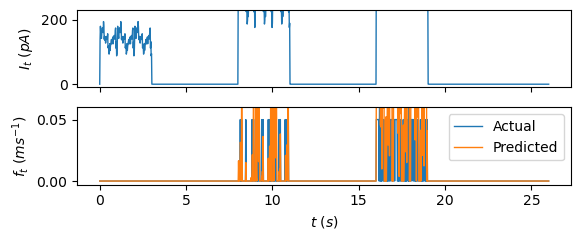

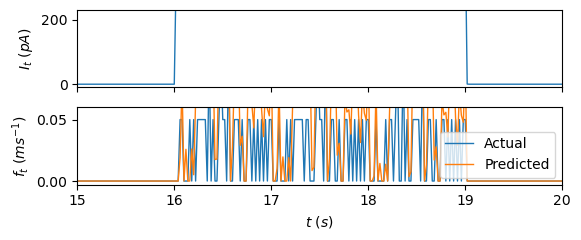

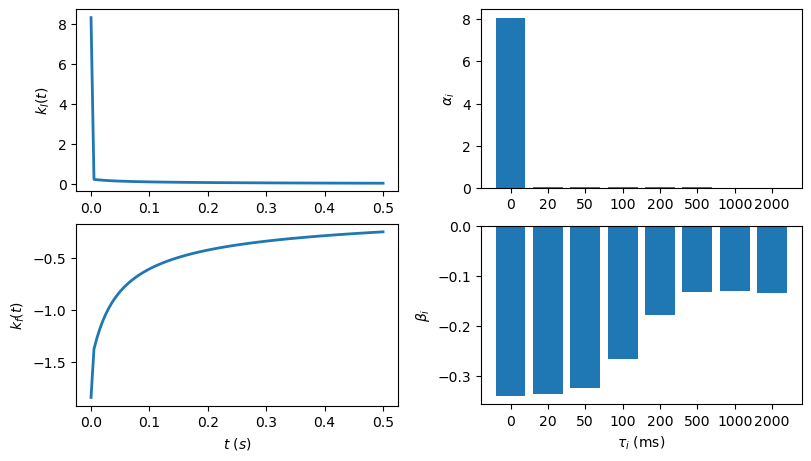

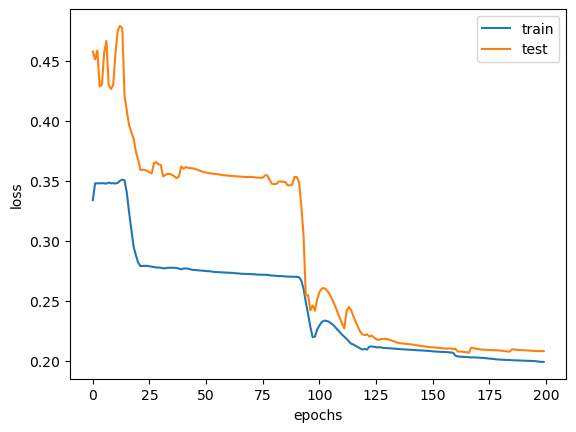

In [24]:
with open(f"model/params_test/{cell_id}.pickle", 'rb') as f:
    params = pickle.load(f)
visualize(cell_id, params)

In [ ]:
model = ExponentialKernelFiringRateModel.from_params(params["params"])
model.g.b